In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2
import tarfile
import pickle

In [2]:
dataset_zip_path = "./data/cifar-10-python.tar.gz"
dataset_folder_path = "cifar-10-batches-py/data_batch_1/"

#### Load the data 

In [3]:
def load_dataset():
    tar_file = tarfile.open(dataset_zip_path, 'r:gz')
    file = tar_file.extractfile(dataset_folder_path)
    data = pickle.load(file, encoding='bytes')
    tar_file.close()
    images = data[b'data']
    return images

def load_images():
    images = load_dataset()
    images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    images = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images]
    images = np.array(images)
    return images

#### Additive noise

In [4]:
def add_noise(img, mean=0, std=100):
    h, w = img.shape
    noise = np.random.normal(mean, std, (h, w))
    img_noisy = img + noise
    img_noisy = np.clip(img_noisy, 0, 255).astype(np.uint8)
    return img, img_noisy

#### Spatial domain filters for image denoising
1. Averaging filter
2. Gaussian filter
3. Median filter

In [5]:
def averaging_filter(img, kernel_size):
    kernel = np.ones((kernel_size, kernel_size), np.float32) / (kernel_size * kernel_size)
    return cv2.filter2D(img, -1, kernel)

def gaussian_filter(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def median_filter(img, kernel_size):
    return cv2.medianBlur(img, kernel_size)

#### Frequency domain filters for image denoising
1. Low pass filter
2. Butterworth filter
3. Gaussian filter

In [6]:
def low_pass_filter(img, d0):
    h, w = img.shape
    img_fft = np.fft.fft2(img)
    img_fft_shift = np.fft.fftshift(img_fft)

    y, x = np.ogrid[-h//2:h-h//2, -w//2:w-w//2]
    mask = x*x + y*y <= d0*d0

    img_fft_shift = img_fft_shift * mask

    img_fft = np.fft.ifftshift(img_fft_shift)
    img_filtered = np.fft.ifft2(img_fft).real
    return img_filtered, img_fft_shift

def low_pass_butterworth_filter(img, d0, n):
    h, w = img.shape
    img_fft = np.fft.fft2(img)
    img_fft_shift = np.fft.fftshift(img_fft)

    y, x = np.ogrid[-h//2:h-h//2, -w//2:w-w//2]
    d = np.sqrt(x*x + y*y)

    butterworth = 1 / (1 + (d / d0)**(2*n))

    img_fft_shift = img_fft_shift * butterworth

    img_fft = np.fft.ifftshift(img_fft_shift)
    img_filtered = np.fft.ifft2(img_fft).real
    return img_filtered, img_fft_shift


def low_pass_gaussian_filter(img, d0):
    h, w = img.shape
    img_fft = np.fft.fft2(img)
    img_fft_shift = np.fft.fftshift(img_fft)

    y, x = np.ogrid[-h//2:h-h//2, -w//2:w-w//2]
    d = np.sqrt(x*x + y*y)

    gaussian = np.exp(-(d**2) / (2 * d0**2))

    img_fft_shift = img_fft_shift * gaussian

    img_fft = np.fft.ifftshift(img_fft_shift)
    img_filtered = np.fft.ifft2(img_fft).real
    return img_filtered, img_fft_shift

#### FFT, IFFT

In [7]:
def fft1d(x):
    N = len(x)
    if N <= 1:
        return x
    else:
        even = fft1d(x[0::2])
        odd = fft1d(x[1::2])
        factor = np.exp(-2j * np.pi * np.arange(N) / N)
        return np.concatenate([even + factor[:N//2] * odd,
                               even + factor[N//2:] * odd])

def ifft1d(X):
    N = len(X)
    if N <= 1:
        return X
    else:
        even = ifft1d(X[0::2])
        odd = ifft1d(X[1::2])
        factor = np.exp(2j * np.pi * np.arange(N) / N)
        return np.concatenate([even + factor[:N//2] * odd,
                               even + factor[N//2:] * odd]) / 2

def fft2d(img):
    M, N = img.shape
    if M % 2 != 0 or N % 2 != 0:
        raise ValueError("Image dimensions must be even for FFT.")
    
    # One-dimention FFT along rows
    F = np.zeros((M, N), dtype=np.complex128)
    for i in range(M):
        F[i, :] = fft1d(img[i])

    # One-dimention FFT along columns
    for j in range(N):
        F[:, j] = fft1d(F[:, j])

    return F

def ifft2d(F):
    M, N = F.shape
    
    # One-dimention IFFT along rows
    f = np.zeros((M, N), dtype=np.complex128)
    for i in range(M):
        f[i, :] = ifft1d(F[i])

    # One-dimentionIFFT along columns
    for j in range(N):
        f[:, j] = ifft1d(f[:, j])

    return f

#### Metrics

In [8]:
PIXEL_MAX = 255.0
PIXEL_MIN = 0.0

def mse(img1, img2):
    """Compute the Mean Squared Error between two images."""
    return np.mean( (img1 - img2) ** 2 )

def psnr(img1, img2):
    """Compute the Peak Signal to Noise Ratio between two images."""
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

#### Add. fucntions

In [9]:
def plot_images(img1, img2):
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(img1)
    axs[1].imshow(img2)
    plt.show()

## Image denoising

#### Add noise to images

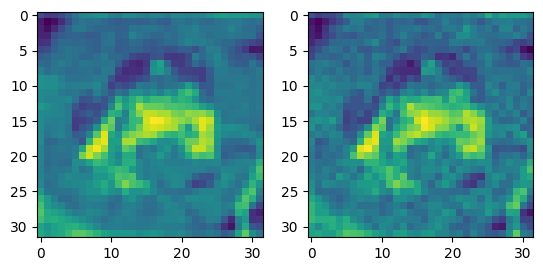

In [10]:
images = load_images()
images = images[:10]
images_noisy = []

for i in range((len(images))):
    img, img_noisy = add_noise(images[i], 0, 10)
    images_noisy.append(img_noisy)

for i in range(1):
    plot_images(images[i], images_noisy[i])

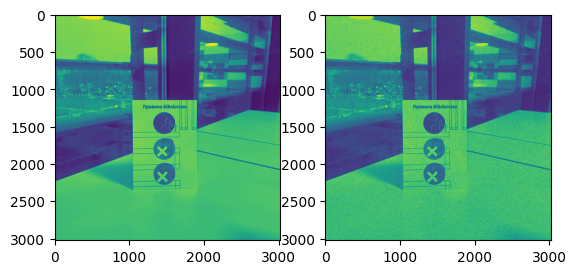

In [11]:
img = cv2.imread('./data/images/input-0.png', cv2.IMREAD_GRAYSCALE)

img, img_noisy = add_noise(img, 0, 60)

plot_images(img, img_noisy)

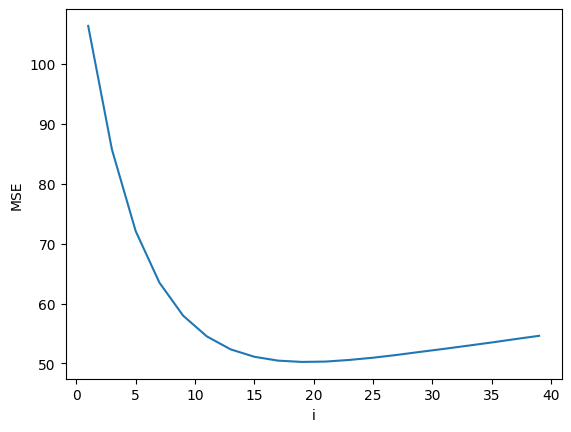

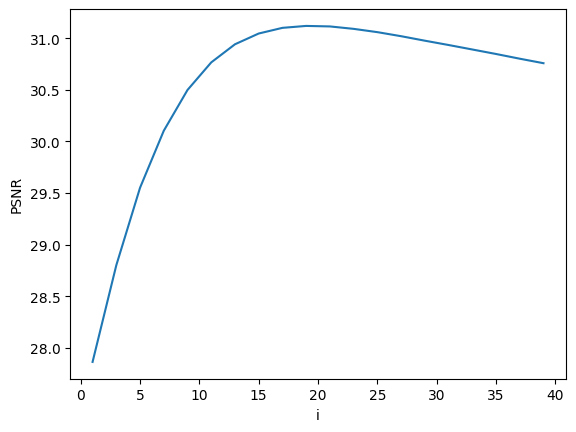

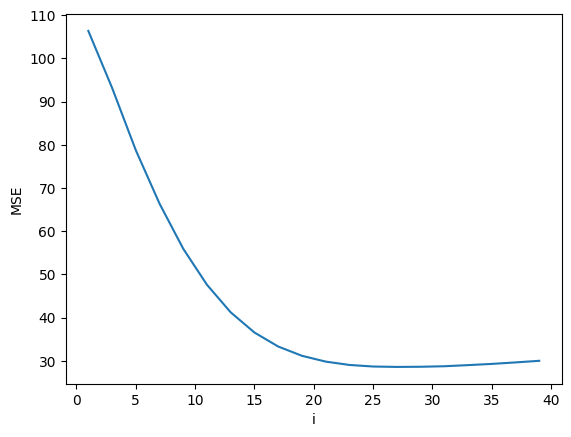

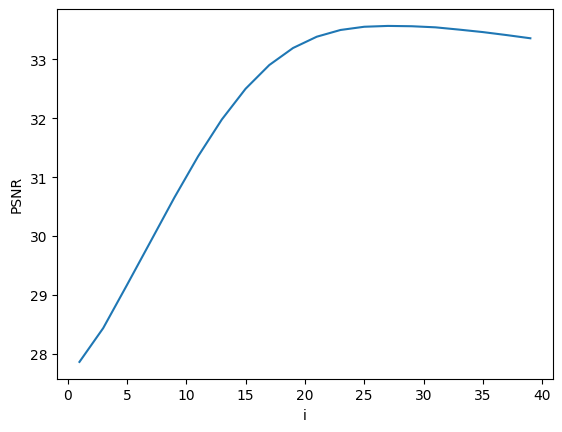

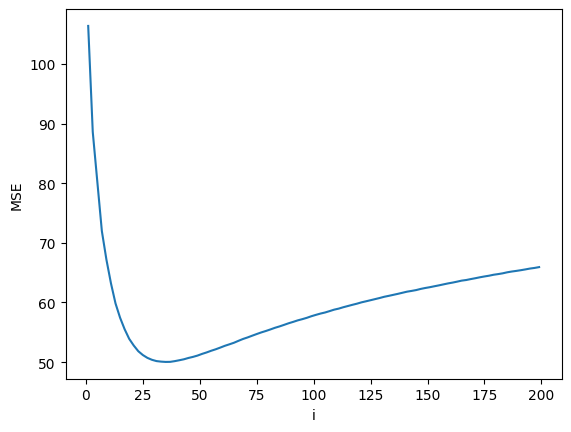

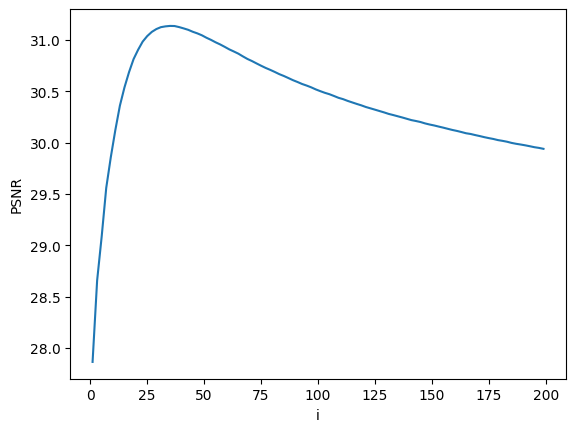

In [12]:
max_value = 40
step = 2

mse_values_averaging = {}
psnr_values_averaging = {}

for i in range (1, max_value, step):
    img_avg = averaging_filter(img_noisy, i)

    mse_value = mse(img, img_avg)
    psnr_value = psnr(img, img_avg)

    mse_values_averaging[i] = mse_value
    psnr_values_averaging[i] = psnr_value

plt.plot(list(mse_values_averaging.keys()), list(mse_values_averaging.values()))
plt.xlabel('i')
plt.ylabel('MSE')
plt.show()

plt.plot(list(psnr_values_averaging.keys()), list(psnr_values_averaging.values()))
plt.xlabel('i')
plt.ylabel('PSNR')
plt.show()

mse_values_median = {}
psnr_values_median = {}

for i in range (1, max_value, step):
    img_avg = median_filter(img_noisy, i)

    mse_value = mse(img, img_avg)
    psnr_value = psnr(img, img_avg)

    mse_values_median[i] = mse_value
    psnr_values_median[i] = psnr_value

plt.plot(list(mse_values_median.keys()), list(mse_values_median.values()))
plt.xlabel('i')
plt.ylabel('MSE')
plt.show()

plt.plot(list(psnr_values_median.keys()), list(psnr_values_median.values()))
plt.xlabel('i')
plt.ylabel('PSNR')
plt.show()

mse_values_gaussian = {}
psnr_values_gaussian = {}

for i in range (1, 200, step):
    img_avg = gaussian_filter(img_noisy, i)

    mse_value = mse(img, img_avg)
    psnr_value = psnr(img, img_avg)

    mse_values_gaussian[i] = mse_value
    psnr_values_gaussian[i] = psnr_value

plt.plot(list(mse_values_gaussian.keys()), list(mse_values_gaussian.values()))
plt.xlabel('i')
plt.ylabel('MSE')
plt.show()

plt.plot(list(psnr_values_gaussian.keys()), list(psnr_values_gaussian.values()))
plt.xlabel('i')
plt.ylabel('PSNR')
plt.show()

/var/folders/pk/k4h295h55z9byh6dngnfg7sh0000gn/T/ipykernel_26591/461379326.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


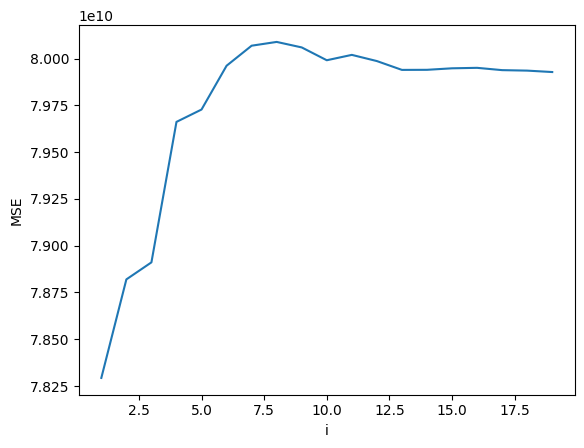

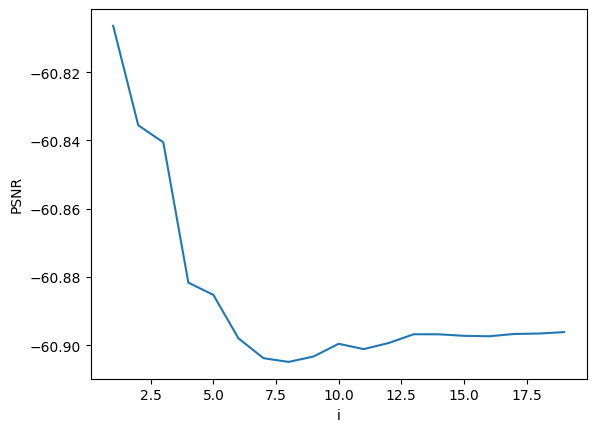

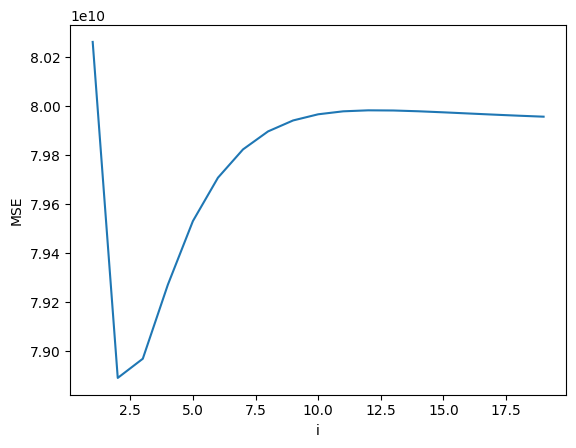

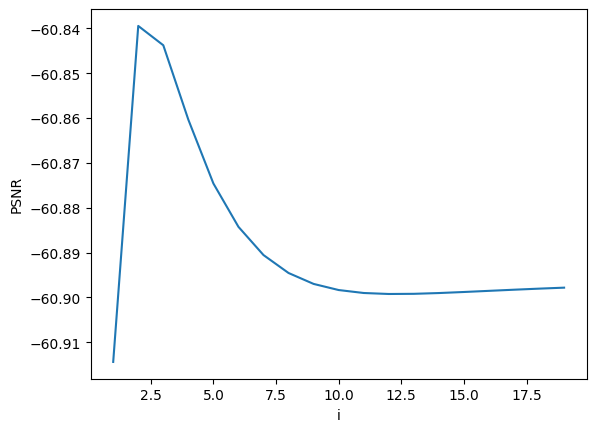

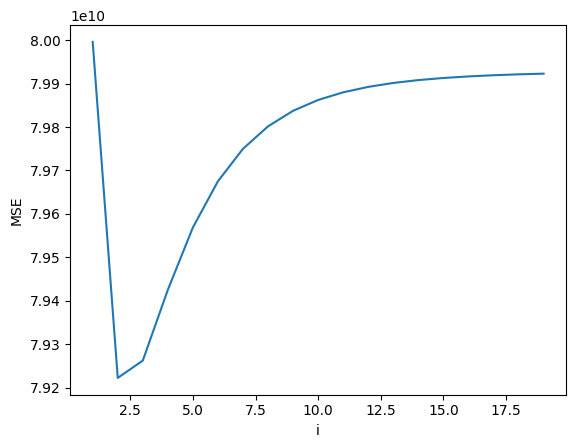

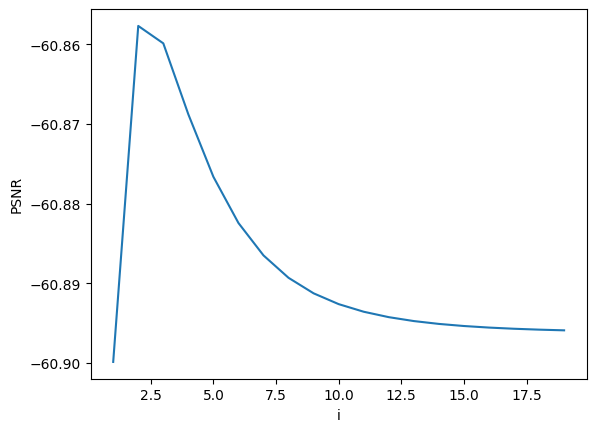

In [13]:
mse_values_low_pass = {}
psnr_values_low_pass = {}

max_value = 20
step = 1

for i in range (1, max_value, step):
    img_avg = low_pass_filter(img_noisy, i)

    mse_value = mse(img, img_avg)
    psnr_value = psnr(img, img_avg)

    mse_values_low_pass[i] = mse_value
    psnr_values_low_pass[i] = psnr_value

plt.plot(list(mse_values_low_pass.keys()), list(mse_values_low_pass.values()))
plt.xlabel('i')
plt.ylabel('MSE')
plt.show()

plt.plot(list(psnr_values_low_pass.keys()), list(psnr_values_low_pass.values()))
plt.xlabel('i')
plt.ylabel('PSNR')
plt.show()

mse_values_low_pass_butterworth = {}
psnr_values_low_pass_butterworth = {}

for i in range(1, max_value, step):
    img_avg = low_pass_butterworth_filter(img_noisy, i, 2)

    mse_value = mse(img, img_avg)
    psnr_value = psnr(img, img_avg)

    mse_values_low_pass_butterworth[i] = mse_value
    psnr_values_low_pass_butterworth[i] = psnr_value

plt.plot(list(mse_values_low_pass_butterworth.keys()), list(mse_values_low_pass_butterworth.values()))
plt.xlabel('i')
plt.ylabel('MSE')
plt.show()

plt.plot(list(psnr_values_low_pass_butterworth.keys()), list(psnr_values_low_pass_butterworth.values()))
plt.xlabel('i')
plt.ylabel('PSNR')
plt.show()


mse_values_low_pass_gaussian = {}
psnr_values_low_pass_gaussian = {}

for i in range(1, max_value, step):
    img_avg = low_pass_gaussian_filter(img_noisy, i)

    mse_value = mse(img, img_avg)
    psnr_value = psnr(img, img_avg)

    mse_values_low_pass_gaussian[i] = mse_value
    psnr_values_low_pass_gaussian[i] = psnr_value

plt.plot(list(mse_values_low_pass_gaussian.keys()), list(mse_values_low_pass_gaussian.values()))
plt.xlabel('i')
plt.ylabel('MSE')
plt.show()

plt.plot(list(psnr_values_low_pass_gaussian.keys()), list(psnr_values_low_pass_gaussian.values()))
plt.xlabel('i')
plt.ylabel('PSNR')
plt.show()


/var/folders/pk/k4h295h55z9byh6dngnfg7sh0000gn/T/ipykernel_26591/461379326.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))


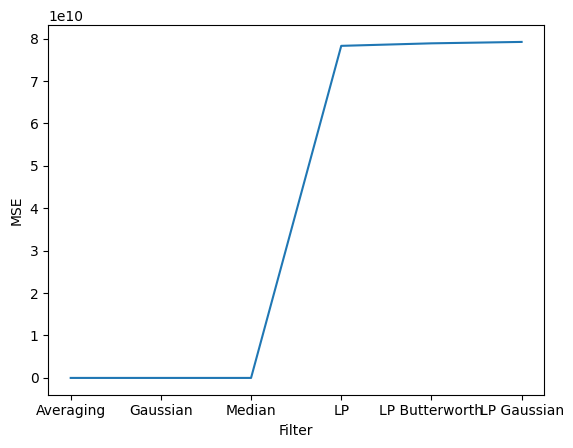

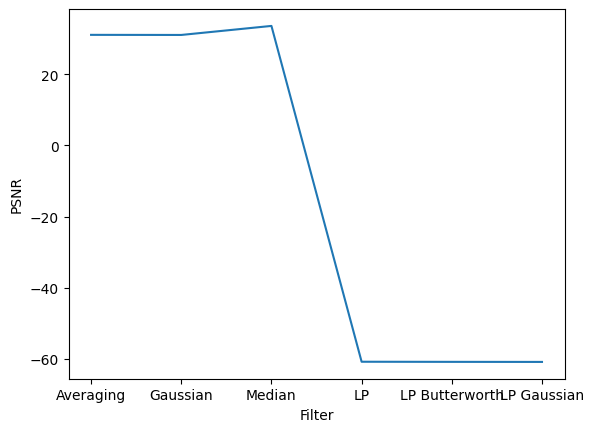

In [18]:
img = cv2.imread('./data/images/input-0.png', cv2.IMREAD_GRAYSCALE)

img, img_noisy = add_noise(img, 0, 60)

img_avg = averaging_filter(img_noisy, 16)
img_gaussian = gaussian_filter(img_noisy, 25)
img_median = median_filter(img_noisy, 29)

img_low_pass = low_pass_filter(img_noisy, 1)
img_low_pass_butterworth = low_pass_butterworth_filter(img_noisy, 2, 2)
img_low_pass_gaussian = low_pass_gaussian_filter(img_noisy, 2)

mse_values = [mse(img, img_avg), mse(img, img_gaussian), mse(img, img_median), mse(img, img_low_pass), mse(img, img_low_pass_butterworth), mse(img, img_low_pass_gaussian)]
psnr_values = [psnr(img, img_avg), psnr(img, img_gaussian), psnr(img, img_median), psnr(img, img_low_pass), psnr(img, img_low_pass_butterworth), psnr(img, img_low_pass_gaussian)]

filters = ['Averaging', 'Gaussian', 'Median', 'LP', 'LP Butterworth', 'LP Gaussian']

plt.plot(filters, mse_values)
plt.xlabel('Filter')
plt.ylabel('MSE')
plt.show()

plt.plot(filters, psnr_values)
plt.xlabel('Filter')
plt.ylabel('PSNR')
plt.show()

In [15]:
def main():
    images = load_dataset()
    images = load_images()
    img = images[2]

    img_fft = fft2d(img)
    img_ifft = ifft2d(img_fft)

    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.title('Original image')
    plt.show()

    plt.figure()
    plt.imshow(np.log(1 + np.abs(img_fft)), cmap='gray')
    plt.title('FFT of the image')
    plt.show()

    plt.figure()
    plt.imshow(np.abs(img_ifft), cmap='gray') 
    plt.title('IFFT of the image')
    plt.show()

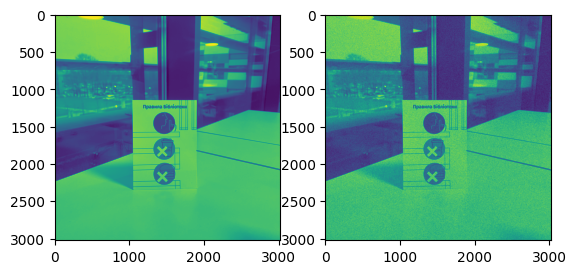

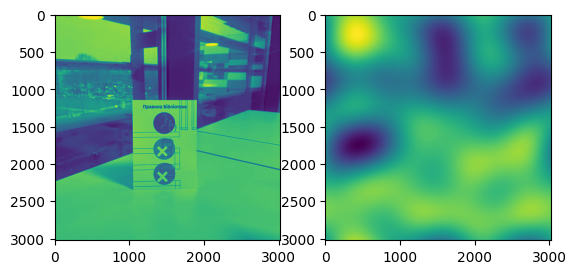

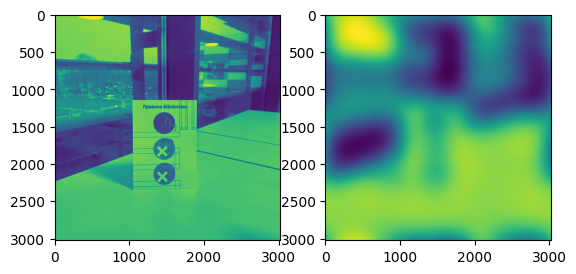

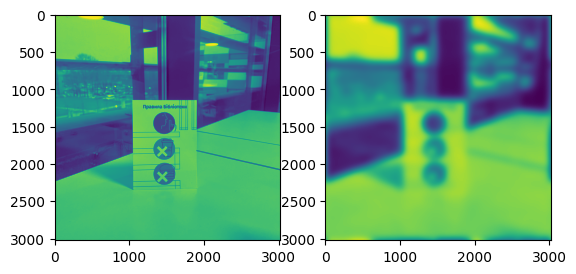

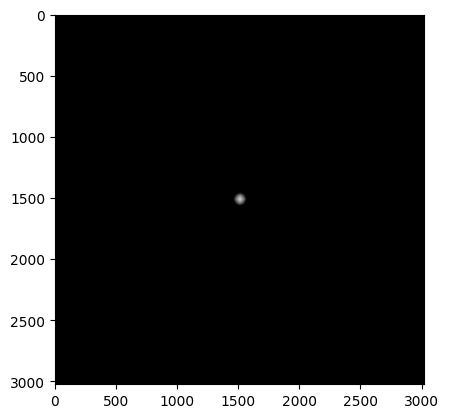

In [16]:

# images = load_dataset()
# images = load_images()
# image = images[2]

image = cv2.imread('./data/images/input-0.png', cv2.IMREAD_GRAYSCALE)

img, img_noisy = add_noise(image, 0, 60)

img_low_pass, img_fft_shift = low_pass_filter(img_noisy, 4)
img_butterworth, img_fft_shift = low_pass_butterworth_filter(img_noisy, 4, 2)
img_gaussian, img_fft_shift = low_pass_gaussian_filter(img_noisy, 10)

plot_images(img, img_noisy)

plot_images(img, img_low_pass)
plot_images(img, img_butterworth)
plot_images(img, img_gaussian)

# also plot the frequency domain representation of the image
plt.imshow(np.log(1 + np.abs(img_fft_shift)), cmap='gray')
plt.show()